In [57]:
import cv2 as cv
import random
import os
import matplotlib.pyplot as plt
import pandas as pd

### Define paths

In [54]:
test_labels = 'dataset_fruits_vegs/test/labels'
test_images = 'dataset_fruits_vegs/test/images'

train_labels = 'dataset_fruits_vegs/train/labels'
train_images = 'dataset_fruits_vegs/train/images'

### Display some images

In [58]:
def show_any_image(images_path):
    while True:
        file_name = random.choice(os.listdir(images_path))
        
        if file_name.endswith(".jpg"):
            img_path = os.path.join(images_path, file_name)
            img = cv.imread(img_path)
            
            if img is None:
                print("failed to load img: {file_name}")
                continue
                
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.show()
            break

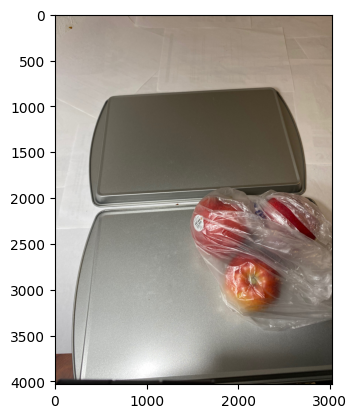

In [59]:
show_any_image(test_images)

In [64]:
def show_any_image_bbox(images_path, labels_path):
    while True:
        # Randomly choose a file from the images directory
        file_name = random.choice(os.listdir(images_path))
        
        if file_name.endswith(".jpg"):
            img_path = os.path.join(images_path, file_name)
            img = cv.imread(img_path)
            
            if img is None:
                print(f"Failed to load image: {file_name}")
                continue

            # Corresponding annotation file in the labels path
            annotation_file = os.path.join(labels_path, os.path.splitext(file_name)[0] + ".txt")
            
            if not os.path.exists(annotation_file):
                print(f"Annotation file not found for {file_name}")
                continue
            
            # Get image dimensions
            img_height, img_width, _ = img.shape

            # Extract bounding boxes from the annotation file
            with open(annotation_file, "r") as f:
                annotations = f.readlines()

            for annotation in annotations:
                class_id, x_center, y_center, width, height = map(float, annotation.strip().split())
                
                # Convert the relative coordinates to absolute pixel values
                x_center_abs = int(x_center * img_width)
                y_center_abs = int(y_center * img_height)
                width_abs = int(width * img_width)
                height_abs = int(height * img_height)

                # Calculate the top-left and bottom-right corners of the bounding box
                x_min = int(x_center_abs - width_abs / 2)
                y_min = int(y_center_abs - height_abs / 2)
                x_max = int(x_center_abs + width_abs / 2)
                y_max = int(y_center_abs + height_abs / 2)

                # Draw the bounding box on the image
                cv.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 8)
                # Optionally add the class ID as a label
                # cv.putText(img, str(int(class_id)), (x_min, y_min - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Convert BGR image to RGB for display with matplotlib
            img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            break


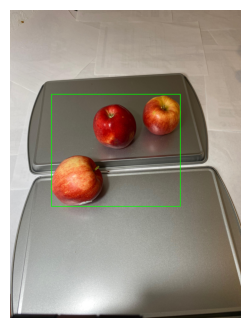

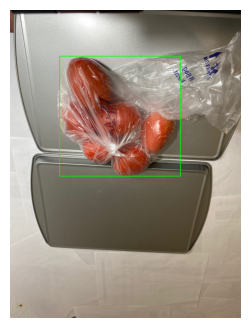

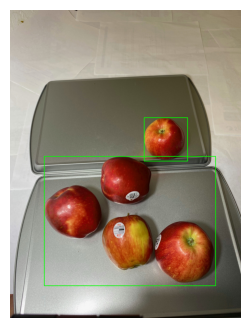

In [65]:
for i in range(3):
    plt.figure(figsize=(4,4))
    show_any_image_bbox(train_images, train_labels)

### Number of files

In [34]:
test = os.listdir("/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/test/test") # your directory path
test_files = len(test)
print("Files in test:", test_files)

Files in test: 1301


#### Dataset
* 3942 imagenes de train
* 653 imagenes de test

### How many images have more than one annotation? in train and test

In [20]:
def count_images_with_multiple_bboxes(dataset_path):
    images_with_multiple_bboxes = 0
    total_images = 0
    
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".jpg"):
            total_images += 1
            annotation_file = os.path.splitext(os.path.join(dataset_path, file_name))[0] + ".txt"
            
            if os.path.exists(annotation_file):
                with open(annotation_file, "r") as f:
                    annotations = f.readlines()
                
                if len(annotations) > 1:
                    images_with_multiple_bboxes += 1
    
    return images_with_multiple_bboxes, total_images

In [21]:
train_path = "/Users/marianata/www/vision_fraud_prevention/dataset_fruits_vegs/train/obj/"

test_multiple_bboxes, test_total = count_images_with_multiple_bboxes(test_path)
train_multiple_bboxes, train_total = count_images_with_multiple_bboxes(train_path)

print(f"Test set: {test_multiple_bboxes}/{test_total} images have more than one bounding box.")
print(f"Train set: {train_multiple_bboxes}/{train_total} images have more than one bounding box.") 

Test set: 109/650 images have more than one bounding box.
Train set: 724/3942 images have more than one bounding box.


### Notes
It is important to notice this because I might need to handle this ltaer, for Yolo will output a pred for every object detected, so if in the image are 3 bananas, yolo or another algorithm, might output 3 preds while the annotations might online contain only one bbox.
I might measure the overlapping between bboxes. And define a certain threshold, if above threshold, the overlapping is high, ad hence the ground truth and predictions are close enough.

1) How much the predicted bounding boxes overlap with the ground truth bbox?


### Number of classes

In [40]:
import os

labels_path = 'dataset_fruits_vegs/train/labels'
labels_test =  'dataset_fruits_vegs/test/labels'

class_indices = set()

for filename in os.listdir(labels_test):
    if filename.endswith('.txt'):
        with open(os.path.join(labels_test, filename), 'r') as file:
            for line in file:
                parts = line.strip().split()
                if parts:  
                    class_index = int(parts[0])  
                    class_indices.add(class_index)  #

num_classes = len(class_indices)
print(f'Number of different classes in training data: {num_classes}')

Number of different classes in training data: 14


### Class names

In [41]:
import pandas as pd

# get a list of all the .txt files in the directory
filenames = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
df = pd.DataFrame(filenames, columns=['filename'])

def extract_class_name(filename):
    '''
    Extracts class name and adjusts for bag status.
    '''
    parts = filename.split('_')
    if len(parts) > 2:
        fruit_name = parts[2]
        
        # remove any unwanted suffixes (e.g., ' - 11.txt')
        fruit_name = fruit_name.split(' - ')[0] 
        
        # check if the filename indicates a bag
        if 'wb' in filename: 
            return f"{fruit_name}-bag"
        elif 'wob' in filename:
            return f"{fruit_name}"
        else:
            return fruit_name
    return None

In [42]:
df['class_name'] = df['filename'].apply(extract_class_name)
unique_classes = df['class_name'].unique()

In [43]:
print(len(unique_classes))

# convert to list
unique_classes_sorted = sorted(unique_classes)
print("Class names", unique_classes_sorted)

14
Class names ['apple', 'apple-bag', 'banana', 'banana-bag', 'blackberries', 'chilli', 'chilli-bag', 'grapes', 'grapes-bag', 'lemon', 'lemon-bag', 'raspberry', 'tomato', 'tomato-bag']


### Class balance

class_name
blackberries    117
raspberry       149
lemon-bag       290
banana-bag      292
grapes-bag      301
grapes          303
apple           303
apple-bag       304
tomato          306
tomato-bag      307
chilli          311
banana          312
chilli-bag      319
lemon           328
Name: count, dtype: int64


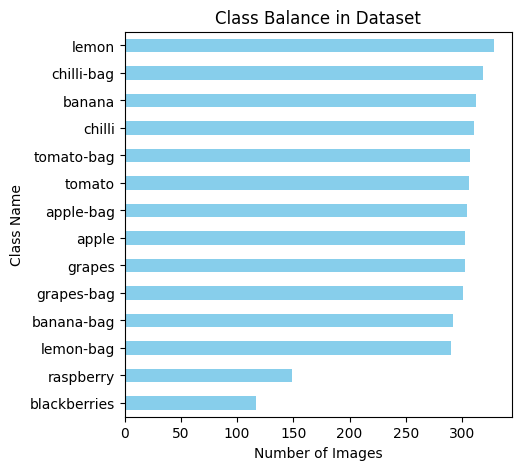

In [44]:
import matplotlib.pyplot as plt

# Group by class and count occurrences
class_distribution = df['class_name'].value_counts().sort_values()

plt.figure(figsize=(5, 5))
class_distribution.plot(kind='barh', color='skyblue')
plt.title('Class Balance in Dataset')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')

print(class_distribution)

In [45]:
import cv2 as cv

images_path = 'dataset_fruits_vegs/train/images'

def parse_annotation_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        annotations = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            annotations.append((class_id, x_center, y_center, width, height))
        return annotations


In [46]:

# Initialize lists to collect data
areas = []
heights = []
widths = []
classes = []


In [47]:
labels_path

'dataset_fruits_vegs/train/labels'

In [48]:
# Process each file
for filename in os.listdir(labels_path):
    if filename.endswith('.txt'):
        base_name = os.path.splitext(filename)[0]
        image_path = os.path.join(images_path, base_name + '.jpg')
        
        # Read the image to get its dimensions
        image = cv.imread(image_path)
        img_height, img_width = image.shape[:2]
        
        # Parse the annotation file
        annotations = parse_annotation_file(os.path.join(labels_path, filename))
        
        for class_id, x_center, y_center, bbox_width, bbox_height in annotations:
            # Convert normalized coordinates to pixel values
            bbox_width_px = bbox_width * img_width
            bbox_height_px = bbox_height * img_height
            
            # Calculate area
            area = bbox_width_px * bbox_height_px
            
            # Collect data
            classes.append(class_id)
            widths.append(bbox_width_px)
            heights.append(bbox_height_px)
            areas.append(area)


Area Statistics:
 count    4.840000e+03
mean     2.462980e+06
std      1.917214e+06
min      2.543200e+04
25%      1.254731e+06
50%      2.045504e+06
75%      3.229496e+06
max      1.156540e+07
Name: area, dtype: float64

Height Statistics:
 count    4840.000000
mean     1434.777273
std       650.559537
min       136.000000
25%      1007.000000
50%      1378.500000
75%      1825.000000
max      3973.000000
Name: height, dtype: float64


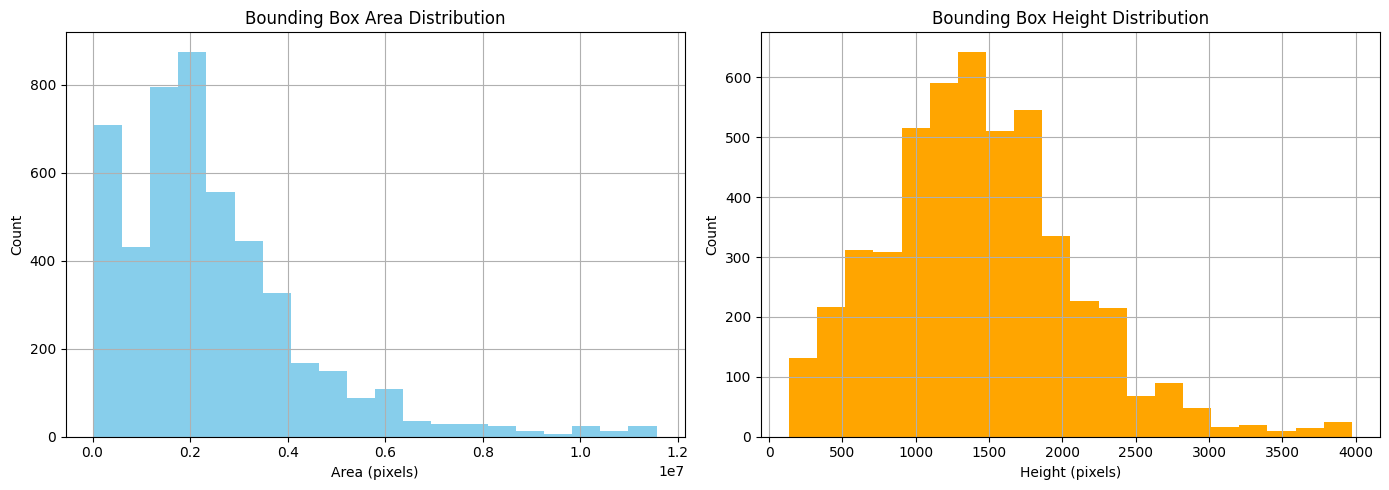

In [50]:
# Create a DataFrame to analyze the data
df = pd.DataFrame({
    'class_id': classes,
    'width': widths,
    'height': heights,
    'area': areas
})

# Descriptive statistics for areas
area_stats = df['area'].describe()
print("Area Statistics:\n", area_stats)

# Descriptive statistics for heights
height_stats = df['height'].describe()
print("\nHeight Statistics:\n", height_stats)

# Plotting distributions
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df['area'].hist(bins=20, color='skyblue')
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['height'].hist(bins=20, color='orange')
plt.title('Bounding Box Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [53]:
df.columns

Index(['class_id', 'width', 'height', 'area'], dtype='object')

In [51]:
def calculate_metrics(df):
    df['area'] = (df['bbox_width'] * df['bbox_height']) / (df['image_width'] * df['image_height']) * 100
    df['height_percent'] = (df['bbox_height'] / df['image_height']) * 100
    return df

# Group data by class and calculate the required metrics
df_grouped = df.groupby('class').agg(
    object_count=('class', 'size'),
    avg_area=('area', 'mean'),
    max_area=('area', 'max'),
    min_area=('area', 'min'),
    max_height=('bbox_height', 'max'),
    min_height=('bbox_height', 'min')
).reset_index()

# Plotting class distribution
plt.figure(figsize=(10, 8))
plt.bar(df_grouped['class'], df_grouped['object_count'])
plt.xlabel('Class')
plt.ylabel('Object Count')
plt.title('Object Count per Class')
plt.xticks(rotation=90)
plt.show()

# Plotting average area per class
plt.figure(figsize=(10, 8))
plt.bar(df_grouped['class'], df_grouped['avg_area'])
plt.xlabel('Class')
plt.ylabel('Average Area (%)')
plt.title('Average Area per Class')
plt.xticks(rotation=90)
plt.show()


KeyError: 'class'